# Processing of Momeni masks

In [1]:
!pip install -e /home/cerebriu/data/RESEARCH/MicrobleedNet/
import nibabel as nib
import nilearn as nil
import numpy as np 
import sys
from scipy.cluster.hierarchy import fcluster, linkage
from scipy.spatial.distance import pdist

import cmbnet.preprocessing.loading as loading
from cmbnet.preprocessing.datasets.momeni import load_MOMENI_raw,  perform_MOMENI_QC

import cmbnet.visualization.utils_plotting as utils_plt
import os
from typing import Tuple, List, Dict
import matplotlib.pyplot as plt


import importlib
import cmbnet
importlib.reload(cmbnet)


Obtaining file:///home/cerebriu/data/RESEARCH/MicrobleedNet
  Preparing metadata (setup.py) ... done
  Attempting uninstall: cmbnet
    Found existing installation: cmbnet 0.1.0
    Uninstalling cmbnet-0.1.0:
      Successfully uninstalled cmbnet-0.1.0
  Running setup.py develop for cmbnet

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


<module 'cmbnet' from '/home/cerebriu/data/RESEARCH/MicrobleedNet/cmbnet/__init__.py'>

In [2]:
input_dir = "/home/cerebriu/data/datasets/raw/MOMENI"
subjects = loading.get_dataset_subjects("momeni", input_dir)

In [3]:
def plot_cross_with_gap(ax, x, y, color='r', gap_size=5, line_length=10, **kwargs):
    """
    Draws a cross on the plot with a specified gap around the center, accounting for y-axis inversion.

    Args:
        ax: The axis on which to draw.
        x, y: The center coordinates of the cross, considering y-axis inversion.
        width, height: The width and height of the plotting area, used for y-axis inversion.
        color: The color of the cross.
        gap_size: The size of the gap around the center.
        line_length: The length of each line of the cross.
    """
    # Vertical line (adjustment only needed for y-axis inversion)
    ax.plot([x, x], [y - gap_size - line_length, y - gap_size], color=color, **kwargs)
    ax.plot([x, x], [y + gap_size, y + gap_size + line_length], color=color, **kwargs)
    
    # Horizontal line
    ax.plot([x - gap_size - line_length, x - gap_size], [y, y], color=color, **kwargs)
    ax.plot([x + gap_size, x + gap_size + line_length], [y, y], color=color, **kwargs)



def check_orientation_consistency(orientation_matrices):
    # Check if all NiBabel objects have the same orientation convention
    orientation_strs = [nib.aff2axcodes(mat) for mat in orientation_matrices]
    return len(set(orientation_strs)) == 1



def plot_processed_mask(mri_im, cmb_im, processed_cmb_im, cmb_coords, zoom_size, metadata_str=None, save_path=None):
    half_size = zoom_size / 2

    # Check if all NiBabel objects have the same orientation
    orientation_matrices = [img.affine for img in [mri_im, cmb_im, processed_cmb_im]]
    if not check_orientation_consistency(orientation_matrices):
        print("Orientation matrices:")
        for i, mat in enumerate(orientation_matrices):
            print(f"Image {i+1}:")
            print(nib.aff2axcodes(mat))
        raise ValueError("All images must have the same orientation.")

    # Extract data from NiBabel objects
    mri_data = mri_im.get_fdata()
    cmb_data = cmb_im.get_fdata()
    out_mask = processed_cmb_im.get_fdata()

    # Calculate the start and end indices for the crop
    start_idx = [max(0, int(cm - half_size)) for cm in cmb_coords[:2]]  # Crop only in the first two dimensions
    end_idx = [min(dim, int(cm + half_size)) for cm, dim in zip(cmb_coords[:2], mri_data.shape[:2])]  # Crop only in the first two dimensions

    # Create slices for cropping
    crop_slice = tuple(slice(start, end) for start, end in zip(start_idx, end_idx))

    # Apply cropping
    t2s_data_cropped = mri_data[crop_slice]
    cmb_cropped = cmb_data[crop_slice]
    pred_cmb_cropped = out_mask[crop_slice]

    fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # 2x2 layout

    # Plot original and generated masks with cross
    axs[1, 0].imshow((t2s_data_cropped[:, :, cmb_coords[-1]]), cmap='gray')  
    axs[1, 0].imshow((cmb_cropped[:, :, cmb_coords[-1]]), alpha=0.5, cmap="Reds")  
    plot_cross_with_gap(axs[1, 0], y=t2s_data_cropped.shape[0] / 2, x=t2s_data_cropped.shape[1] / 2, color='yellow', line_length=25, gap_size=15, linewidth=1)
    axs[1, 0].set_title('Original Mask')

    axs[1, 1].imshow((t2s_data_cropped[:, :, cmb_coords[-1]]), cmap='gray')  
    axs[1, 1].imshow((pred_cmb_cropped[:, :, cmb_coords[-1]]), alpha=0.5, cmap="Reds")  
    plot_cross_with_gap(axs[1, 1], y=t2s_data_cropped.shape[0] / 2, x=t2s_data_cropped.shape[1] / 2, color='yellow', line_length=25, gap_size=15, linewidth=1)
    axs[1, 1].set_title('Generated Mask')

    # Plot the full view without zoom
    axs[0, 0].imshow((mri_data[:, :, cmb_coords[-1]]), cmap='gray')
    plot_cross_with_gap(axs[0, 0], y=cmb_coords[0], x=cmb_coords[1], color='yellow', line_length=25, gap_size=15, linewidth=1)

    # Plot the full view with zoom
    axs[0, 1].imshow((t2s_data_cropped[:, :, cmb_coords[-1]]), cmap='gray')  
    plot_cross_with_gap(axs[0, 1], y=t2s_data_cropped.shape[0] / 2, x=t2s_data_cropped.shape[1] / 2, color='yellow', line_length=25, gap_size=15, linewidth=1)

    # Add metadata to the second plot
    if metadata_str:
        axs[1, 0].text(0.5, 1.15, metadata_str, transform=axs[1, 0].transAxes, fontsize=10, ha='center')

    for ax in axs.ravel():
        ax.axis('off')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        plt.close(fig)
    else:
        plt.show()


In [4]:
class Args:
    def __init__(self, input_dir = "/home/cerebriu/data/datasets/raw/MOMENI", dataset_name="momeni"):
        self.input_dir = input_dir
        self.dataset_name = dataset_name

------------------------------------------------
221_T2_MRI_SWI_BFC_50mm_HM
------------------------------------------------
(136, 142, 21)
6 point relative


Looping over tolerances:   0%|          | 0/649 [00:00<?, ?it/s]/home/cerebriu/data/RESEARCH/MicrobleedNet/cmbnet/preprocessing/process_masks.py:190: RuntimeWarning: invalid value encountered in scalar divide
  intensity_diff = abs((volume[neighbor] - current_intensity) / current_intensity )
Looping over tolerances: 100%|██████████| 649/649 [00:12<00:00, 52.74it/s]


6 point normal


Looping over tolerances:   1%|          | 20/2000 [00:00<01:20, 24.54it/s]


6 running_average relative


Looping over tolerances:   2%|▏         | 10/649 [00:00<00:52, 12.24it/s]


6 running_average normal


Looping over tolerances:   1%|          | 20/2000 [00:00<01:26, 22.82it/s]


26 point relative


Looping over tolerances: 100%|██████████| 649/649 [00:44<00:00, 14.44it/s]


26 point normal


Looping over tolerances:   1%|          | 20/2000 [00:00<01:23, 23.58it/s]


26 running_average relative


Looping over tolerances:   2%|▏         | 10/649 [00:00<00:57, 11.15it/s]


26 running_average normal


Looping over tolerances:   1%|          | 20/2000 [00:00<01:27, 22.52it/s]


CMBs: [(136, 142, 21)]
		Thresholds for RegionGrowing --> Max. distance =5, Max Size=340
		Processing CMB annotations 
		Optimization selected connectivity=26, intensity_mode=point, diff_mode=relative with n_pixels=27.
shape: (176, 256, 80)
(136, 142, 21)


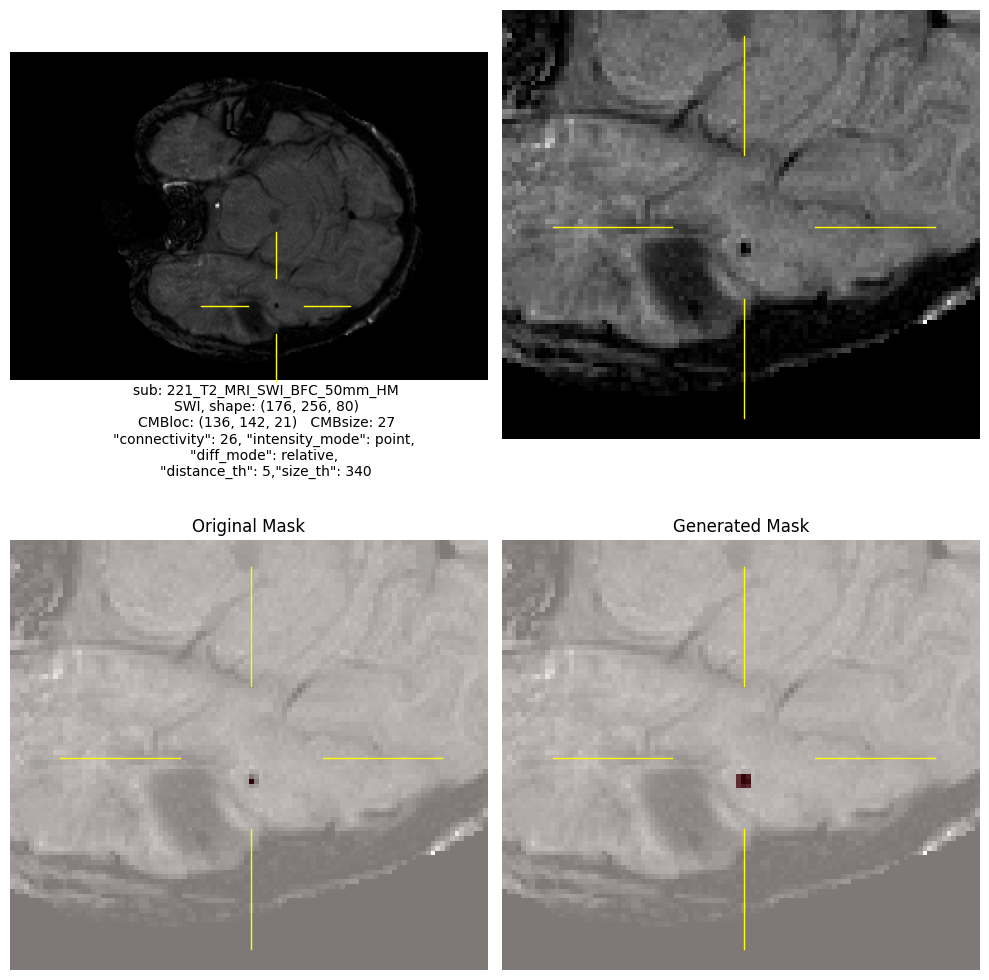

In [5]:
results = {}
subjects_temp = subjects
subjects_temp = ['221_T2_MRI_SWI_BFC_50mm_HM']
for subject in subjects_temp:
    print("------------------------------------------------")
    print(subject)
    print("------------------------------------------------")

    # Load data
    args = Args()
    sequences_raw, labels_raw, sequence_type, com_list = load_MOMENI_raw(args.input_dir, subject)
    sequences_qc, labels_qc, labels_metadata, msg = perform_MOMENI_QC(subject, sequences_raw, labels_raw, com_list, "")

    mri_im_raw = sequences_raw[sequence_type]
    rawcmb_im_raw = labels_raw[sequence_type]
    grownmask_raw = labels_qc[sequence_type]

    results[subject] = {
        "raw": (sequences_raw, labels_raw, sequence_type, com_list),
        "qc": (sequences_qc, labels_qc, labels_metadata, msg)
    }
    print(f"CMBs: {com_list}")
    print(msg)

    print(f"shape: {mri_im_raw.shape}")

    # Plotting processed masks for each center of mass
    for i, CM in enumerate(com_list):
        filename_temp = os.path.join(args.input_dir, f"MOMENI_{subject}.png")                                
        metadata_str = f"""\
        sub: {subject}
        {sequence_type}, shape: {mri_im_raw.shape}
        CMBloc: {CM}   CMBsize: {labels_metadata[sequence_type]["CMBs_old"][i]['size']}
        "connectivity": {labels_metadata[sequence_type]["CMBs_old"][i]['region_growing']['connectivity']}, "intensity_mode": {labels_metadata[sequence_type]["CMBs_old"][i]['region_growing']['intensity_mode']}, 
        "diff_mode": {labels_metadata[sequence_type]["CMBs_old"][i]['region_growing']['diff_mode']}, 
        "distance_th": {labels_metadata[sequence_type]["CMBs_old"][i]['region_growing']['distance_th']},"size_th": {labels_metadata[sequence_type]["CMBs_old"][i]['region_growing']['size_th']}"""
        utils_plt.plot_processed_mask(mri_im_raw, rawcmb_im_raw, grownmask_raw, CM, 100, metadata_str=metadata_str, save_path=filename_temp)

In [6]:
labels_metadata

{'SWI': {'healthy': 'no',
  'CMBs_old': {0: {'size': 27,
    'CM': (136, 142, 21),
    'region_growing': {'selected_tolerance': 9900.0,
     'n_tolerances': 649,
     'elbow_i': 648,
     'elbow2end_tol': [27, 27],
     'connectivity': 26,
     'intensity_mode': 'point',
     'diff_mode': 'relative',
     'distance_th': 5,
     'size_th': 340}}}}}

In [9]:
mr_data = sequences_raw[sequence_type].get_fdata()
np.min(mr_data)
cm = com_list[0]
print(cm)
point = (136, 200, 21)
print(
    mr_data[cm],
    mr_data[point],
    "\n",
    abs(mr_data[cm]-    mr_data[point] / mr_data[cm])
    )

(136, 142, 21)
2.2923364639282227 240.86611938476562 
 102.78216859891477
